## Heuristic 5 - Careless usage of Anonimity Mining

Through Anonimity Mining, TCash users are able to receive TORN token as a reward for using the application. This is done in a sequence of two steps:

1. Anonimity Points (AP) are claimed for already spent notes. The quantity of AP obtained depends on how many blocks the note was in a TCash pool, and the pool where it was.
2. Using the TCash Automated Market Maker (AMM), users can exchange anonimity points for TORN.


From a pure data point of view, this actions are seen as transactions with the TCash Miner. An example of transaction (1) can be seen [here](https://etherscan.io/tx/0x7680b7617931851c5de686c06370bf852d2cd1e32de984d1860ed8510bc44c0b) and an example of transaction (2) can be seen [here](https://etherscan.io/tx/0xb7b41774e17961452c307dfc9515f59ed583e8c6f00a74a716d64e6bd365f223). 

What can be seen clearly by decoding the input data field of these transactions is that transactions of type (1) call the TCash miner method `reward` and the ones of type (2) the method `withdraw`. Transactions of type (2) are the ones we are interested in, since they give us the following information:

* Amount of AP being swapped to TORN.
* Address of TORN recipient. 

Making the assumption that users are swapping the totality of their AP, and that those AP have been claimed for a single note, then we can link deposit and withdrawal transactions with the following procedure:

1. Check if the recipient address of a transaction of type (2) has done a deposit or a withdraw in TCash.
2. If the address is included in the set of deposit (withdraw) addreses, then check all deposits (withdraws) of that address, convert AP into number of blocks according to the pool the deposit was done, and then search for a withdra transaction with block number equal to

    ```deposit_blocks + AP_converted_blocks = withdraw_blocks```
    
    
3. When such a withdraw (deposit) is found, then the two transactions are considered linked.

### Results
Results are given in a dictionary, each element has the following structure:

```
(withdraw_hash, withdraw_address, AP_converted_blocks): [(deposit_hash, deposit_address), ...]
```

In this compact manner we have the information about the withdraw transactions with their addresses and their linking to deposit transactions with their addresses. We also have the amount of blocks that the notes were deposited in the TCash pool.

In [1]:
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
from os.path import exists

In [2]:
with open('../data/tornado_pools.json') as json_file:
    tornado_addresses = json.load(json_file)

deposit_txs = pd.read_csv("../data/lighter_complete_deposit_txs.csv")
deposit_txs["tcash_pool"] = deposit_txs["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])

withdraw_txs = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
withdraw_txs["tcash_pool"] = withdraw_txs["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])

miner_txs = pd.read_csv("../data/lighter_miner_txs.csv")

In [3]:
w_miner_txs = miner_txs[miner_txs["function_call"] == "w"]
w_miner_txs.head()

,Unnamed: 0,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,...,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,function_call,anonimity_points,recipient_address
0,0,0x3a22fe99fd6c27b507760cb20a1d3ffae9ccd320dca8...,1122,142,0x80e179c4a2f057be91573b32bece53888fb48311,0x746aebc06d2ae31b71ac51429a19d54e797878e9,0,434790,232500000000,8009441,...,2021-04-03 19:23:24 UTC,12168479,0xb88d592cf1a1d399e2621b8ca7aef638d9d7b3dad39b...,NaN,NaN,NaN,232500000000,w,227319444.0,0x84bb14595fd30a53cbe18e68085d42645901d8b6
1,1,0x3331a615c119a9958b4429e0789674d5219aa16f23d5...,1678,168,0xbe4d1e137a24af091be80ae58d652279665e3a27,0x746aebc06d2ae31b71ac51429a19d54e797878e9,0,434790,196500000000,12080586,...,2021-03-31 23:25:33 UTC,12150112,0xb97682f9cb2da20ec91feb61eb44fee72a16d7924e19...,NaN,NaN,NaN,196500000000,w,46294475.0,0x1dc09454a6128182d65cd2e8478d9b445c3267d5
3,3,0x5097c46458696ec07fecf989c60cfb26ec37eabc3734...,6310,83,0xbe4d1e137a24af091be80ae58d652279665e3a27,0x746aebc06d2ae31b71ac51429a19d54e797878e9,0,400000,17500000000,4131879,...,2021-07-11 08:40:51 UTC,12804973,0x70008e988a388c9b1b691540c35800584eb5b0bcb7c9...,NaN,NaN,NaN,17500000000,w,173174856.0,0xd2800879f604cd13d7d9e8738c080408d7105c60
4,4,0x78b487413b9996ff504bf24b7ee4109f4e74acd3f66d...,7023,137,0xbe4d1e137a24af091be80ae58d652279665e3a27,0x746aebc06d2ae31b71ac51429a19d54e797878e9,0,400000,51000000730,9509885,...,2021-08-03 15:34:58 UTC,12953119,0x59aba14dac8f1f4f09e14a7a70b4e4e8e9686a487194...,NaN,NaN,NaN,51000000730,w,219334984.0,0x4bd4e5818d30b47bc771e5fd271bd9c15570be30
5,5,0x30d9b4b39ab002d6f655d2a4fc2c158c2bf599eae7b4...,1381,240,0x49136693081f2c18e2cf14428dd78cd90a22dc1f,0x746aebc06d2ae31b71ac51429a19d54e797878e9,0,400000,23000000000,8390223,...,2021-07-13 09:03:45 UTC,12817885,0xf6a8a55c2ab263028901493a875aa6c6ae542c94b327...,NaN,NaN,NaN,23000000000,w,191255216.0,0xd05564eef07a73c31f9e8ee840abda76e2a99a66


In [4]:
recipient_addresses = set(w_miner_txs["recipient_address"])

In [5]:
mining_pool_rates ={
    "0.1 ETH": 4, 
    "1 ETH": 20, 
    "10 ETH": 50, 
    "100 ETH": 400, 
    "100 DAI": 2, 
    "1000 DAI": 10, 
    "10000 DAI": 40, 
    "100000 DAI": 250, 
    "5000 cDAI": 2, 
    "50000 cDAI": 10,
    "500000 cDAI": 40, 
    "5000000 cDAI": 250,
    "0.1 WBTC": 15, 
    "1 WBTC": 120, 
    "10 WBTC": 1000
}
mining_pools = list(mining_pool_rates.keys())

In [6]:
# Drop all the txs that are not from the mining pools
deposit_txs = deposit_txs[deposit_txs["tcash_pool"].isin(mining_pools)]
withdraw_txs = withdraw_txs[withdraw_txs["tcash_pool"].isin(mining_pools)]

unique_deposit_addresses = set(deposit_txs["from_address"])
unique_withdraw_addresses = set(withdraw_txs["recipient_address"])

In [7]:
def address_to_txs_and_blocks(txs_df, tx_type) -> dict:
    
    assert tx_type in ["deposit", "withdraw"], "Transaction type error"
    
    address_field = "from_address" if tx_type == "deposit" else "recipient_address"
    
    addr_to_txs_and_blocks_dict: dict = {}
        
    for _, row in tqdm(txs_df.iterrows(), mininterval=1, total=len(txs_df)):
        if row[address_field] not in addr_to_txs_and_blocks_dict.keys():
            addr_to_txs_and_blocks_dict[row[address_field]] = {row.tcash_pool: [(row.hash, row.block_number)]}
            
        elif row.tcash_pool not in addr_to_txs_and_blocks_dict[row[address_field]].keys():
            addr_to_txs_and_blocks_dict[row[address_field]].update({row.tcash_pool: [(row.hash, row.block_number)]})
        
        else:
            addr_to_txs_and_blocks_dict[row[address_field]][row.tcash_pool].append((row.hash, row.block_number))
    
    return addr_to_txs_and_blocks_dict

In [8]:
addr2deposits = address_to_txs_and_blocks(deposit_txs, "deposit")
addr2withdraws = address_to_txs_and_blocks(withdraw_txs, "withdraw")

100%|██████████| 82677/82677 [00:08<00:00, 10011.27it/s]


In [9]:
'''
To classify the addresses by their inclusion in the unique_deposit_addresses and 
the unique_withdraw_addresses sets.
'''

def is_D_type(address):
    return (address in unique_deposit_addresses) and (address not in unique_withdraw_addresses)

def is_W_type(address):
    return (address not in unique_deposit_addresses) and (address in unique_withdraw_addresses)

def is_DW_type(address):
    return (address in unique_deposit_addresses) and (address in unique_withdraw_addresses)

In [10]:
def ap2blocks(anonimity_points: int, pool: str) -> float:
    rate = mining_pool_rates[pool]
    
    return anonimity_points/rate

In [11]:
def _D_type_anonimity_heuristic(miner_tx) -> dict:
    
    d_addr = miner_tx.recipient_address
    
    d_addr2w: dict = {d_addr: {}}
    
    for d_pool in addr2deposits[d_addr]:
        for (d_hash, d_blocks) in addr2deposits[d_addr][d_pool]:
            delta_blocks = ap2blocks(miner_tx.anonimity_points, d_pool)
            
            for w_addr in addr2withdraws.keys():
                if d_pool in addr2withdraws[w_addr].keys():
                    
                    for (w_hash, w_blocks) in addr2withdraws[w_addr][d_pool]:
                        if d_blocks + delta_blocks == w_blocks:
                            if d_hash not in d_addr2w[d_addr].keys():
                                d_addr2w[d_addr][d_hash] = [(w_hash, w_addr, delta_blocks)]
                            else:
                                d_addr2w[d_addr][d_hash].append((w_hash, w_addr, delta_blocks))
    
    return d_addr2w         

In [12]:
def _W_type_anonimity_heuristic(miner_tx) -> dict:
    
    w_addr = miner_tx.recipient_address
    
    w_addr2d: dict = {w_addr: {}}
    
    for w_pool in addr2withdraws[w_addr]:
        for (w_hash, w_blocks) in addr2withdraws[w_addr][w_pool]:
            delta_blocks = ap2blocks(miner_tx.anonimity_points, w_pool)
            
            for d_addr in addr2deposits.keys():
                if w_pool in addr2deposits[d_addr].keys():
                    
                    for (d_hash, d_blocks) in addr2deposits[d_addr][w_pool]:
                        if d_blocks + delta_blocks == w_blocks:
                            if w_hash not in w_addr2d[w_addr].keys():
                                w_addr2d[w_addr][w_hash] = [(d_hash, d_addr, delta_blocks)]
                            else:
                                w_addr2d[w_addr][w_hash].append((d_hash, d_addr, delta_blocks))
    
    return w_addr2d  

In [13]:
def anonimity_mining_heuristic(miner_tx) -> dict:
    linked_txs: dict = {}
    
    if is_D_type(miner_tx.recipient_address):
        d_dict = _D_type_anonimity_heuristic(miner_tx)
        if len(d_dict[miner_tx.recipient_address]) != 0:
            linked_txs["D"] = d_dict
        return linked_txs
        
    elif is_W_type(miner_tx.recipient_address):
        w_dict = _W_type_anonimity_heuristic(miner_tx)
        if len(w_dict[miner_tx.recipient_address]) != 0:
            linked_txs["W"] = w_dict
        return linked_txs
        
    elif is_DW_type(miner_tx.recipient_address):
        d_dict = _D_type_anonimity_heuristic(miner_tx)
        if len(d_dict[miner_tx.recipient_address]) != 0:
            linked_txs["D"] = d_dict
            
        w_dict = _W_type_anonimity_heuristic(miner_tx)
        if len(w_dict[miner_tx.recipient_address]) != 0:
            linked_txs["W"] = w_dict
        

        return linked_txs
    
    return linked_txs

In [14]:
def apply_anonimity_mining_heuristic(miner_txs) -> dict:
    
    total_linked_txs = {"D": {}, "W": {}}
    
    for miner_tx in tqdm(miner_txs.itertuples(), mininterval=3, total=len(miner_txs)):
        linked_txs = anonimity_mining_heuristic(miner_tx)
        if len(linked_txs) != 0:
            if "D" in linked_txs.keys():
                if len(linked_txs["D"]) != 0:
                    total_linked_txs["D"].update(linked_txs["D"])
            if "W" in linked_txs.keys():
                if len(linked_txs["W"]) != 0:
                    total_linked_txs["W"].update(linked_txs["W"])
    
    return total_linked_txs

In [15]:
# For caching these results,
# with open("../data/heuristic_5_linked_txs.json", "w") as outfile:
#    json.dump(total_linked_txs, outfile, indent=4)


In [16]:
def load_raw_linked_transactions(filepath):
    if exists(filepath):
        with open(filepath) as json_file:
            total_linked_txs = json.load(json_file)
        return total_linked_txs
    else:
        total_linked_txs = apply_anonimity_mining_heuristic(miner_txs)
        return total_linked_txs

In [17]:
total_linked_txs = load_raw_linked_transactions("../data/heuristic_5_linked_txs.json")

In [18]:
'''
The final version of the results is obtained applying this function
to the output of the 'apply_anonimity_mining_heuristic' function.

wb2d -> withdraws and blocks to deposits
'''

def _wb2d(total_linked_txs) -> dict:
    
    w2d: dict = {}
        
    for elem in total_linked_txs["W"].items():
        for addr in total_linked_txs["W"].keys():
            for hsh in total_linked_txs["W"][addr]:
                delta_blocks = total_linked_txs["W"][addr][hsh][0][2]
                w2d[(hsh, addr, delta_blocks)] = [(t[0],t[1]) for t in total_linked_txs["W"][addr][hsh]]
    
    for elem in total_linked_txs["D"].items():
        for addr in total_linked_txs["D"].keys():
            
            for hsh in total_linked_txs["D"][addr]:
                
                for tx_tuple in total_linked_txs["D"][addr][hsh]:
                    if tx_tuple[0] not in w2d.keys():
                        w2d[tuple(tx_tuple)] = [(hsh, addr)]
                    else:
                        if (hsh, addr) not in w2d[tx_tuple]:
                            w2d[tuple(tx_tuple)].append((hsh, addr))
    
    return w2d

In [19]:
w2d = _wb2d(total_linked_txs)

### Results exploration

In [20]:
D_linked_addresses = total_linked_txs["D"].keys()
W_linked_addresses = total_linked_txs["W"].keys()

In [21]:
def get_number_of_linked_txs(total_linked_txs, link_type) -> dict:
    
    assert link_type in ["D", "W"], "Invalid link type"
    
    linked_addresses = list(total_linked_txs[link_type].keys())
    
    addr2txcount: dict = {}
    
    for addr in linked_addresses:
        addr2txcount[addr] = len(total_linked_txs[link_type][addr])
    
    return addr2txcount

In [22]:
def get_number_of_linked_addrs(total_linked_txs, link_type) -> dict:
    
    assert link_type in ["D", "W"], "Invalid link type"

    linked_addresses = list(total_linked_txs[link_type].keys())

    addr2addrcount: dict = {}
        
    for addr in linked_addresses:
        tx_tuples = list(chain(*total_linked_txs[link_type][addr].values()))
        
        addr_count = len(set([t[1] for t in tx_tuples]))
        
        addr2addrcount[addr] = addr_count
    
    return addr2addrcount

In [23]:
D_linked_counts = get_number_of_linked_txs(total_linked_txs, "D")
W_linked_counts = get_number_of_linked_txs(total_linked_txs, "W")

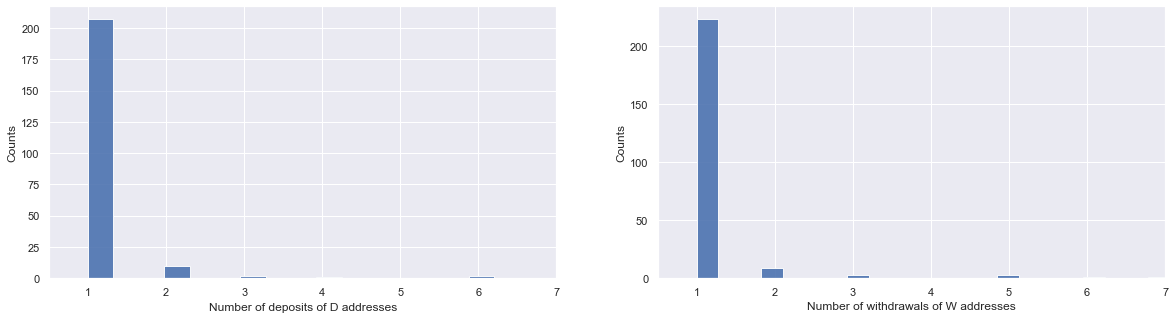

In [24]:
sns.set_theme(style="darkgrid")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.hist(D_linked_counts.values(), alpha=0.9, bins=40, align="mid")
ax1.set_xlim((0.5, 7))
ax1.set_xlabel("Number of deposits of D addresses")
ax1.set_ylabel("Counts")

ax2.hist(W_linked_counts.values(), alpha=0.9, bins=40, align="mid")
ax2.set_xlim((0.5, 7))
ax2.set_xlabel("Number of withdrawals of W addresses")
ax2.set_ylabel("Counts")

plt.show()

In [25]:
D_linked_addr_counts = get_number_of_linked_addrs(total_linked_txs, "D")
W_linked_addr_counts = get_number_of_linked_addrs(total_linked_txs, "W")

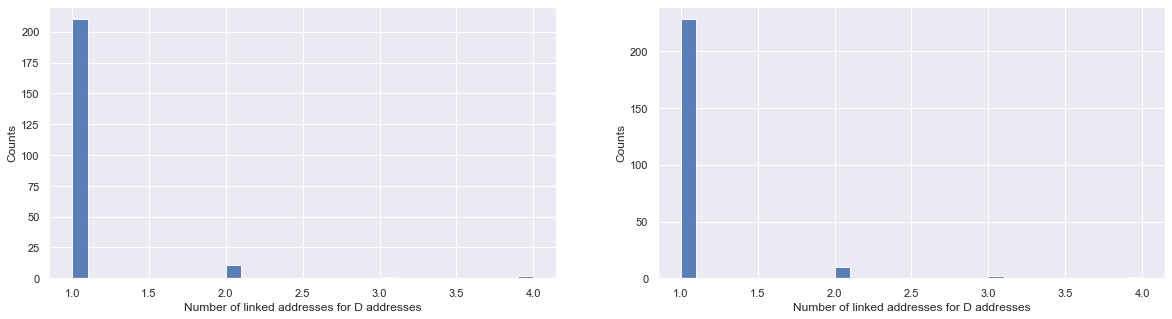

In [26]:
sns.set_theme(style="darkgrid")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.hist(list(D_linked_addr_counts.values()), bins=30, alpha=0.9)
ax1.set_xlabel("Number of linked addresses for D addresses")
ax1.set_ylabel("Counts")

ax2.hist(list(W_linked_addr_counts.values()), bins=30, alpha=0.9)
ax2.set_xlabel("Number of linked addresses for D addresses")
ax2.set_ylabel("Counts")

plt.show()

In [27]:
def get_block_number(total_linked_txs):
    
    blocks: list = []
    
    for link_type in ["D", "W"]:
        for addr in total_linked_txs[link_type]:
            for tx in total_linked_txs[link_type][addr]:
                for tx_tuple in total_linked_txs[link_type][addr][tx]:
                    blocks.append(tx_tuple[2])
    
    return blocks

In [28]:
blocks = get_block_number(total_linked_txs)

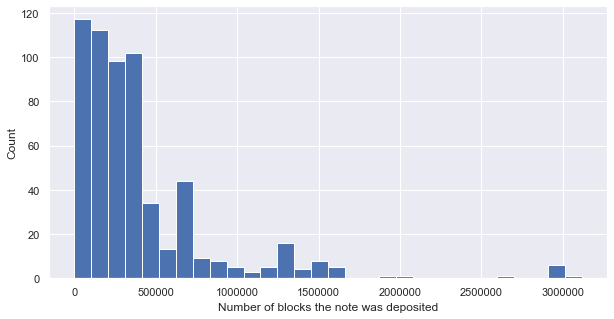

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(blocks, bins=30)
ax.ticklabel_format(style="plain")
ax.set_xlabel("Number of blocks the note was deposited")
ax.set_ylabel("Count")
plt.show()